In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import h5py
from pathlib import Path
import os
import sys
sys.path.append(os.getcwd() + '/../..')
sys.path.append(os.getcwd() + '/..')
from filepaths import filepath_from_ml_artifacts_uri
from analysis.iclr.plotting import settings, fig_size, cb_line_cycler, cb_line_cycler_solid, cb_marker_cycler, savefig
from plot_hdf5_dataset import plot_dataset
from iclr_paper_path import get_paper_path
import matplotlib
settings()
import matplotlib.pyplot as plt
from brokenaxes import brokenaxes

In [2]:
path_runs = 'runs_iclr_steam_bnode.csv'
df = pd.read_csv(path_runs)
for col in df.columns:
    print(col)

Start Time
Duration
Run ID
Name
Source Type
Source Name
User
Status
activation
alpha_mu_override
alpha_sigma_override
batch_size_override
batch_size_test
batches_per_epoch_override
beta1_adam_override
beta2_adam_override
beta_start_override
clip_grad_norm_override
control_encoder_linear
controls_to_decoder
dataset_name
decoder_linear
early_stopping_patience_override
early_stopping_threshold_mode_override
early_stopping_threshold_override
evaluate_at_control_times_override
hidden_dim_output_nn
include_reconstruction_loss_state0_override
initialization_type
initialization_type_ode
initialization_type_ode_matrix
job 1 ended by
job 2 ended by
job 3 ended by
koopman_mpc_mode
lat_controls_dim
lat_ode_type
lat_parameters_dim
lat_state_mu_independent
lat_states_dim
linear_hidden_dim
load_pretrained_model
load_seq_len_override
load_trained_model_for_test
lr_start_override
main_training
main_training_0_activate_deterministic_mode_after_this_phase
main_training_0_alpha_mu
main_training_0_alpha_si

In [3]:
def get_dataset_paths(lat_ode_type):
    df_lat = df[df['lat_ode_type'] == lat_ode_type]
    if lat_ode_type == 'variance_constant':
        df_lat = df_lat[df_lat['lr_start_override'] == 0.0001]
    run_ids = df_lat['Run ID']
    paths = []
    betas = []
    n_states = []
    for run_id in run_ids:
        path = 'mlflow-artifacts:/765349530991563084/' + run_id + '/artifacts/dataset.hdf5'
        paths.append(path)
        betas.append(df_lat[df_lat['Run ID'] == run_id]['beta_start_override'].values[0])
        n_states.append(df_lat[df_lat['Run ID'] == run_id]['lat_dim_states_populated_common_test'].values[0] if lat_ode_type != 'vanilla' else 16)
    return paths, betas, n_states

_paths_var_const, betas, n_states = get_dataset_paths('variance_constant')
print(_paths_var_const)
print(betas)
print(n_states)

['mlflow-artifacts:/765349530991563084/69660da6114e46c2843b392ec8254f53/artifacts/dataset.hdf5', 'mlflow-artifacts:/765349530991563084/dcd1a8656ca64f488e639c9597b0edf8/artifacts/dataset.hdf5', 'mlflow-artifacts:/765349530991563084/5de20fe3c6154bea9ccfc172636e2e39/artifacts/dataset.hdf5', 'mlflow-artifacts:/765349530991563084/964ac187cdcf452595c8fb489778b3e0/artifacts/dataset.hdf5']
[0.005, 0.01, 0.05, 0.1]
[17.0, 11.5, 6.0, 6.0]


In [4]:
path_ROM_dataset = filepath_from_ml_artifacts_uri(_paths_var_const[0])
norm_dataset = h5py.File(path_ROM_dataset, 'r')

compare_outputs = True
if compare_outputs:
    _variable = 'outputs'
    _variable_hat = 'outputs_hat'
else:
    _variable = 'states'
    _variable_hat = 'states_hat'

mean = norm_dataset['train'][_variable][:].mean(axis=(0, 2))
var = norm_dataset['train'][_variable][:].std(axis=(0, 2))

def calculate_normed_loss(outputs, outputs_hat, mean=var):
    mean = np.expand_dims(mean, axis=(0, 2))

    x = np.divide(outputs, mean)
    xhat = np.divide(outputs_hat, mean)

    # calculate rmse loss
    residual = x - xhat
    loss = np.square(residual).mean()
    loss = np.sqrt(loss)
    max = residual.max()
    return loss *100, max * 100

print('percentage values!')

_paths, _betas, n_states = get_dataset_paths('variance_constant')
loss_BNODE_constant = []
max_BNODE_constant = []
betas_BNODE_constant = _betas
for i, path in enumerate(_paths):
    dataset = h5py.File(filepath_from_ml_artifacts_uri(path), 'r')
    outputs = dataset['common_test'][_variable][:]
    rmse, max = calculate_normed_loss(outputs, dataset['common_test'][_variable_hat][:])
    loss_BNODE_constant.append(rmse)
    max_BNODE_constant.append(max)
    print('BNODE const. beta {}: {:3f} max: {:3f}'.format(betas_BNODE_constant[i], rmse, max))
_dict = {'n_states': n_states, 'loss': loss_BNODE_constant, 'betas': betas_BNODE_constant, 'max': max_BNODE_constant}
df_BNODE_constant = pd.DataFrame(_dict)

_paths, _betas, n_states = get_dataset_paths('variance_dynamic')
loss_BNODE_dynamic = []
max_BNODE_dynamic = []
betas_BNODE_dynamic = _betas
for i, path in enumerate(_paths):
    dataset = h5py.File(filepath_from_ml_artifacts_uri(path), 'r')
    outputs = dataset['common_test'][_variable][:]
    rmse, max = calculate_normed_loss(outputs, dataset['common_test'][_variable_hat][:])
    loss_BNODE_dynamic.append(rmse)
    max_BNODE_dynamic.append(max)
    print('BNODE var. beta {}: {:3f} max: {:3f}'.format(betas_BNODE_dynamic[i], rmse, max))
_dict = {'n_states': n_states, 'loss': loss_BNODE_dynamic, 'betas': betas_BNODE_dynamic, 'max': max_BNODE_dynamic}
df_BNODE_dynamic = pd.DataFrame(_dict)

# add here NODE
_paths = 'mlflow-artifacts:/287498415586464143/aed77c5e803a47d79cff399e09ebf6b8/artifacts/dataset.hdf5'
dataset = h5py.File(filepath_from_ml_artifacts_uri(_paths), 'r')
outputs = dataset['common_test'][_variable][:]
rmse, max = calculate_normed_loss(outputs, dataset['common_test'][_variable_hat][:])
print('NODE: {:3f} max: {:3f}'.format(rmse, max))
loss_NODE = [rmse]
max_NODE = [max]
betas_NODE = [None]
n_states_NODE = [102]
_dict = {'n_states': n_states_NODE, 'loss': loss_NODE, 'betas': betas_NODE, 'max': max_NODE}
df_NODE = pd.DataFrame(_dict)

# select best beta for each number of states
df_BNODE_constant = df_BNODE_constant.sort_values('loss').groupby('n_states').first().reset_index()
df_BNODE_dynamic = df_BNODE_dynamic.sort_values('loss').groupby('n_states').first().reset_index()

percentage values!
BNODE const. beta 0.005: 1.844363 max: 30.305045
BNODE const. beta 0.01: 2.439827 max: 31.644421
BNODE const. beta 0.05: 4.159172 max: 42.776242
BNODE const. beta 0.1: 4.223219 max: 36.813571
BNODE var. beta 0.1: 5.081184 max: 36.140235
NODE: 6.180773 max: 76.905460


In [5]:
df_BNODE_constant

,n_states,loss,betas,max
0,17.0,1.844363,0.005,30.305045
1,11.5,2.439827,0.010,31.644421
2,6.0,4.159172,0.050,42.776242
3,6.0,4.223219,0.100,36.813571


In [6]:
df_BNODE_dynamic

,n_states,loss,betas,max
0,6.0,5.081184,0.1,36.140235


In [7]:
df_NODE

,n_states,loss,betas,max
0,102,6.180773,None,76.90546


finding path that contains "code", then going up one level to find "LaTeX"
e:\projects\balanced_neural_odes_internal\code\python\analysis\iclr
e:\projects\balanced_neural_odes_internal\code\python\analysis
e:\projects\balanced_neural_odes_internal\code\python
e:\projects\balanced_neural_odes_internal\code
e:\projects\balanced_neural_odes_internal
E:\projects\balanced_neural_odes_internal\LaTeX\ICLR 2025 Template\figures\BNODE_steam\rmse_vs_n_states_steam.png
E:\projects\balanced_neural_odes_internal\LaTeX\ICLR 2025 Template\figures\BNODE_steam\rmse_vs_n_states_steam.svg


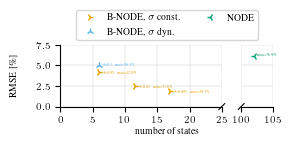

In [43]:
fig = plt.figure(figsize=fig_size(0.8, n_figs_per_width=2))
bax = brokenaxes(xlims=((0, 25), (100, 105)))

offset_x = 0.5

# set marker cycler
bax.set_prop_cycle(cb_marker_cycler)

bax.plot(df_BNODE_constant['n_states'], df_BNODE_constant['loss'], label=r'B-NODE, $\sigma$ const.', markersize=5, markeredgewidth=1)
for x, y, beta, max in zip(df_BNODE_constant['n_states'], df_BNODE_constant['loss'], df_BNODE_constant['betas'], df_BNODE_constant['max']):
    bax.text(x + offset_x, y, r'\noindent$\beta$' + '={}, max={}\%'.format(beta, np.round(max, 1)),
             fontsize=3, color='#E69F00', ha='left', rotation=0, va='center')

bax.plot(df_BNODE_dynamic['n_states'], df_BNODE_dynamic['loss'], label=r'B-NODE, $\sigma$ dyn.', markersize=5, markeredgewidth=1)
for x, y, beta, max in zip(df_BNODE_dynamic['n_states'], df_BNODE_dynamic['loss'], df_BNODE_dynamic['betas'], df_BNODE_dynamic['max']):
    bax.text(x + offset_x, y, r'\noindent$\beta$' + '={}, max={}\%'.format(beta, np.round(max, 1)),
             fontsize=3, color='#56B4E9', ha='left', rotation=0, va='center')

bax.plot(df_NODE['n_states'], df_NODE['loss'], label=r'NODE', markersize=5, markeredgewidth=1)
for x, y, max in zip(df_NODE['n_states'], df_NODE['loss'], df_NODE['max']):
    bax.text(x + offset_x, y, 'max={}\%'.format(np.round(max, 1)),
             fontsize=3, color='#009E73', ha='left', rotation=0, va='center')

bax.set_ylabel(r'RMSE [\%]')
bax.grid(which='both', linewidth=0.2)
bax.set_ylim(0, 7.5)

bax.set_xlabel(r'number of states')

bax.legend(loc='lower center', ncol=2, shadow=False, frameon=True, bbox_to_anchor=(0.5, 1.0))
savefig(fig, get_paper_path('BNODE_steam', 'rmse_vs_n_states_steam'))